In [1]:
%matplotlib inline
import pymc3 as pm  # asi importamos PyMC3!
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
palette = 'colorblind'
sns.set_palette(palette); sns.set_color_codes(palette)

# 1. Programación probabilística

Como explicamos en el capítulo anterior, la estadística Bayesiana es conceptualmente simple. Un modelo Bayesiano/probabilístico se construye y se resuelve según el siguiente esquema general. Los datos $D$ son fijos (no podemos cambiar lo que hemos medido) y los valores  de los parámetros $\theta$ se hacen variar. La incertidumbre en los parámetros y la relación entre datos y parámetros $p(D|\theta)$ se representan usando distribuciones de probabilidad. Luego, el teorema de Bayes es usado para transformar la distribución _a priori_ $p(\theta)$ (lo que sabemos de un problema antes de observar los datos), en la distribución _a posteriori_ $p(\theta|D)$ (lo que aprendemos una vez observados los datos). La principal dificultad técnica en estadística Bayesiana reside en que los modelos probabilísticos suelen ser analíticamente intratables. A fin de poder resolverlos se recurre a métodos numéricos que pueden ser considerados como _motores universales de inferencia_ (cuyo funcionamiento será explicado más adelante). El hecho que tales motores sean posibles ha motivado el de la [programación probabilística](http://probabilistic-programming.org/wiki/Home), este tipo de lenguajes permiten una separación clara entre la creación de los modelos y el proceso de inferencia. 

Un lenguaje de programación probabilístico es en lineas generales un lenguaje que permite al usuario describir un modelo probabilístico completo escribiendo una pocas lineas de código, las necesarias para describir el modelo, y luego proceder a realizar la inferencia de forma automática. Se espera que la programación probabilística tenga un gran impacto en estadística, _machine learning_ y otras disciplinas al permitir que científicos construyan modelos complejos en menor tiempo y de forma menos propensa a errores.

Una buena analogía sobre el impacto que un lenguaje de programación puede tener en la ciencia es la introducción del lenguaje de programación Fortran hace más de 6 décadas. Fortran permitió a los científicos, por primera vez, abstraerse de muchos de los detalles computacionales y centrarse en la construcción de métodos numéricos, modelos y simulaciones de una manera más natural. De manera similar, se espera que los lenguajes de programación probabilísticos escondan del usuario detalles sobre como las probabilidades son manipuladas y como se lleva a cabo la inferencia dejando que los usuarios se centren en la especificación del modelo y en el análisis e interpretación de los resultados.

## 1.1 PyMC3

PyMC3 es una librería para programación probabilística bajo Python. La última versión disponible es la "release candidate 4", a pesar de que todavía no ha alcanzado el _status_ de estable, PyMC3 es lo suficientemente madura para resolver muchos problemas estadísticos.  PyMC3 permite crear modelos probabilísticos usando una sintaxis intuitiva y fácil de leer que es muy similar a la sintaxis usada para describir modelos probabilísticos.

La mayoría de las funciones de PyMC3 están escritas en Python. Mientras que las partes computacionalmente demandantes están escritas en NumPy y [Theano](http://deeplearning.net/software/theano/index.html). Theano es una librería que permite definir, optimizar, y evaluar expresiones matemáticas que involucren arreglos multidimensionales de forma eficiente. Entre las ventajas de Theano encontramos:

* Trabaja junto con NumPy
* Las expresiones escritas con Theano se _traducen_ automáticamente a C y se compilan (aumentando la velocidad del código).
* Theano _sabe matemática_ lo que le permite realizar varias optimizaciones de forma automática y permite además calcular gradientes (es la generalización del concepto de derivada a más de una una dimensión). El cálculo del gradiente es necesario para varios métodos numéricos incluidos la minimización de funciones y para algunos métodos de muestreo (o en forma rimbombante _métodos universales de inferencia_).

Los métodos de muestreo (_samplers_ en inglés) son esenciales en estadística Bayesiana por que permiten obtener aproximaciones al _a posteriori_ sin necesidad de restringir los al uso de los _a prioris_ conjugados. PyMC3 provee varios de estos métodos de muestreo. 

Dada la centralidad de los métodos computacionales en el análisis Bayesiano moderno, antes de pasar a ver como usar PyMC3 es necesario discutir, de forma breve, el funcionamiento de estos métodos de muestreo y algunas de sus propiedades.

## 1.2 Métodos de muestreo (_samplers_)

Existen varios métodos numéricos que pueden funcionar como métodos de muestreo o _motores de inferencia_. La mayoría de ellos están basados en la siguiente idea: aún cuando no es posible obtener analíticamente la distribución _a posteriori_ suele ser posible tomar muestras de dicha distribución de forma tal de obtener una descripción aproximada, pero confiable. La gran mayoría de los métodos de muestreo (al menos los más usados actualmente) se clasifican dentro de la familia de los _Markov Chain Monte Carlo_ y son lo que brevemente discutiremos a continuación.

### 1.2.1 Markov Chain Monte Carlo (MCMC).

Todos los métodos MCMC generan muestras del _a posteriori_ por medio de la construcción de una cadena de Markov reversible que tiene como distribución de equilibrio a la distribucion _a posteriori_. 

Probablemente para la mayoría de ustedes la oración previa no dice demasiado, es por ello que iremos desmenuzando la oración a fin de entenderla conceptualmente.  

[Markov Chain Monte Carlo](http://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) es el nombre de una familia de algoritmos que son extensamente usados en casi todas las ramas de la ciencia. El principal propósito de estos algoritmos es el de obtener muestras de una distribución de probabilidad que es difícil (o imposible) de tratar analíticamente. Esto se logra mediante la construcción de una cadena de Markov que tiene como distribución de equilibrio la distribución que nos interesa. Esto quiere decir que el método garantiza (bajo ciertas condiciones) que mientras más muestras tomemos más nos aproximaremos a la distribución deseada. En este contexto una cadena es un objeto matemático que describe una secuencia de estados y las probabilidades de transición entre dichos estados. Una cadena de Markov es un tipo especial de cadena donde la probabilidad de pasar al próximo estado depende solo del estado actual y no del camino por el cual que se llegó al estado actual.

Un ejemplo clásico de una cadena de Markov es la llamada caminata del borracho. Supongamos que la caminata es unidimensional y que los estados están representados por números enteros. En cada paso el borracho puede o bien moverse a la derecha o bien a la izquierda, con una cierta probabilidad (supongamos que 0.5 a cada lado). En algún momento el borracho se encontrará en la posición -4, por lo que el siguiente estado podría ser o bien -5 o bien -3 (con igual probabilidad), pero independiente de si en el paso anterior el borracho estaba en -5 o en -3. En este ejemplo se ve claramente que la probabilidad de pasar de un estado al otro no depende de los pasos previos del borracho si no solo de su posición actual.

Bien, ahora que sabemos que es una cadena de Markov nos queda ver que es un _Monte Carlo_. Un Monte Carlo es un método que hace uso de números (pseudo)aleatorios para simular algún proceso. Monte Carlo es el nombre de un casino en Mónaco donde el tío de uno de los creadores del método solía apostar. La idea central de un método de Monte Carlo es que es posible estudiar sistemas complicados muestreándolos en vez de estudiándolos directamente. Por ejemplo si querés saber las probabilidades de ganar en un juego de solitario una opción es tratar de obtener la respuesta de forma analítica (algo un poco complicado dada la naturaleza combinatoria del problema) La otra opción es simplemente jugar tantas partidas de solitario como se pueda y estimar la probabilidad de ganar en el solitario a partir de esas muestras. De hecho es exactamente este problema el que se planteó Stanislaw Ulam (circa 1940), un de los autores del método de Monte Carlo, mientras se recuperaba de una cirugía y jugaba al solitario. En esa época las computadoras empezaban a ser una realidad y este y otros investigadores rápidamente vieron el potencial de resolver infinidad de problemas mediante simulaciones simples. La simplicidad de la idea y el aumento incesante del poder de cálculo ha hecho que la aplicación y utilidad de los métodos de Monte Carlo no haya hecho otra cosa que aumentar con el paso de los años.

Dentro de la gran familia de algoritmos de Markov Chain Monte Carlo el más usado probablemente sea el método de Metropolis-Hastings, además prácticamente todos los demás MCMC se pueden ver comovariantes de este.

#### 1.2.1.1 Metropolis-Hastings

El algoritmo de [Metropolis–Hastings](http://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) permite obtener muestras de cualquier distribución de probabilidad $p(x)$ siempre y cuando sea posible computar un valor proporcional a $p(x)$. Esto es muy útil, por que en muchos problemas incluida la estadística Bayesiana lo que suele ser difícil de computar es el factor de normalización (el denominador en el teorema de Bayes). Para distribuciones simples existen métodos más directos para muestrearlas, pero Metropolis-Hastings al igual que otros métodos MCMC se vuelven cada vez más útiles a medida que las dimensiones aumentan.


El algoritmo de Metropolis-Hastings consiste en los siguientes pasos

1. Elegir un estado inicial $x_i$ (al azar o haciendo uso de información disponible). En el caso de la estadística Bayesiana un estado es un valor posible para un parámetro de nuestro modelo.
2. Elegir un nuevo estado $x_{i+1}$ muestreando a partir de una distribución conocida $q(x_{i+1}|x_{i})$, por ejemplo una distribución Gaussiana. En otras palabras perturbamos el estado $x_i$.
3. Computar la probabilidad de aceptar (p_a) el nuevo estado según la siguiente regla: 

    $$p_a(x_{i+1} | x_i) = \min\left(1,\frac{p(x_{i+1})}{p(x_{i})}\frac{q(x_{i} | x_{i+1})}{q(x_{i+1} | x_{i})}\right)$$

4. Si la probabilidad computada en 3 es más grande que un valor tomado de una distribución uniforme sobre el intervalo [0, 1] aceptar el nuevo estado, caso contrario mantenerse en el estado actual.
5. Iterar desde 2 hasta _convergencia_

Un par de detalles para tener en cuenta

* Si el nuevo estado se propone usando una distribución simétrica, se obtiene:

    $$p_a(x_{i+1} | x_i) = \min\left(1,\frac{p(x_{i+1})}{p(x_{i})}\right)$$

* Los pasos 3 y 4 implican que siempre aceptamos un paso que nos mueve hacia una zona de mayor probabilidad. Estados menos probables son aceptados probabilísticamente, de acuerdo al cociente entre la probabilidad del estado propuesto $x_{i+1}$ y el estado actual $x_i$.
* La distribución objetivo (el _a posteriori_ en nuestro caso) lo vamos a aproximar construyendo un histograma a partir de los valores que iremos muestreando.  Deberemos guardar (por ejemplo en una lista o array) los valores de los estados en dos situaciones: Si aceptamos movernos a un nuevo estado $x_{i+1}$ guardamos el valor de $x_{i+1}$, si rechazamos movernos desde $x_i$ a un nuevo estado $x_{i+1}$ guardamos el valor del estado $x_i$. Esto es importante si no nos movemos volvemos a _anotar el valor_ del estado en el que estamos. Al finalizar tendremos una cadena con varios estados. Si todo _salió bien_ la frecuencia de cada estado en nuestra cadena será (aproximadamente) proporcional a la probabilidad de dicho estado según dicta la distribución de probabilidad que queríamos muestrear (y que no podíamos resolver analíticamente).

#### 1.2.1.2 Monte Carlo Hamiltoniano y NUTS

Existe una garantía teórica de que la distribución muestreada usando Metrópolis-Hastings (como otros MCMC) convergerá a una distribución estacionaria. Esto quiere decir que aún si empezamos en valores alejados de la distribución correcta dado el suficiente tiempo conseguiremos tener una muestra que es realmente representativa de la distribución correcta. 

Sin embargo, en la práctica y para cierto tipo de problemas la convergencia puede ser demasiado lenta. En esos casos se dice que se tiene un _mezclado lento_. Es por ello que se han propuesto (y se siguen proponiendo) modificaciones al algortimo de Metropolis-Hastings. Una de estas modificaciones se llama Monte Carlo Hamiltoniano, tambien conocido como Monte Carlo Híbrido (HMC). En este método cada estado propuesto es obtenido simulando una partícula que se mueve por una superficie (la distribución de probabilidad que queremos muestrear), la partícula se mueve según su energía potencial y cinética (la suma de ambas es el hamiltoniano). Cada estado propuesto de esta forma es aceptado o rechazado de igual forma que en Metropolis-Hastings. el Nombre de híbrido proviene de que se combina Metrópolis-Hastings con dinámica molecular (otra técnica de muestreo). Una de las ventajas de este método es que las nuevas posiciones propuestas tienen una alta probabildiad de ser aceptadas, incluso para posiciones distantes respecto de la posición anterior. 

El Monte Carlo Hamiltoniano es mucho más cpu-demandante que Metropolis-Hastings; La razón es que es necesario computar el gradiente de la función potencial, al mismo tiempo los metodos HMC resultan en un mejor y más rápido mezclado. Para algunos problemas, especialmente para modelos complejos con mucho parámetros, esta situación de compromiso termina favoreciendo al HMC. 

Un problema con los métodos HMC es que el método necesita de dos parámetros los cuales deben ajustarse empíricamente. Es por ello que se han propuesto métodos para ajustar los paráetros de forma automática. Uno de estos métodos, recientemente propuesto, es llamado _No-U-Turn Sampler_ (NUTS). Este método ha probado ser de mucha utilidad al ofrecer la eficiencia de muestreo del HMC, pero sin la necesidad de ajustar manualmente ningún parámetro.

### 1.2.2 Métodos no markovianos

Metrópolis-Hastings y NUTS, son métodos markovianos, ya que se basan en construir una cadena de markov como se explicó en la sección anterior. Existen otros _motores de inferencia_ que no son markovianos. En general estos métodos son más rápidos, pero solo proveen aproximaciones al _a posteriori_, recordemos que los métodos como Metrópolis-Hastings proveen la respuesta correcta en el límite de infinitas muestras.

#### 1.2.2.1 Computación usando una grilla

Usar una grilla para aproximar un cálculo es un método de fuerza bruta muy usado para resolver muchos problemas (no solo problemas en estadística Bayesiana). La idea es la siguiente, aún cuando si no podemos calcular el _a posteriori_ de forma directa suele ser posible computar el _a priori_ y el _likelihood_ para un número dado de puntos. De hecho este es el mismo supuesto de los métodos MCMC. Asumamos que queremos computar el _a posteriori_ para un modelo con un solo parámetro. En este caso el método de la grilla sería:

1.	 Definir un intervalo razonable para calcular el parámetro (en general esto estará definido por el _a priori_).
2.	 Ubicar una grilla de puntos (por lo general equidistante) en ese intervalo.
3. Para cada punto de la grilla multiplicar el valor del _a priori_ y del _likelihood_.

Optionalmente podríamos querer normalizar los valores computados, es decir dividir el valor obtenido en cada punto por la suma de los valores obtenidos en todos los puntos.

Es facil ver que a medida que se aumenta la cantidad de puntos de la grilla se obtiene mejor resultados. De hecho, si tomaramos un número infinito de puntos obtendríamos la respuesta correcta de forma exacta. El problema de esta aproximación es que no escala bien con el número de dimensiones. A medida que se incrementa el número de parámetros (dimensiones) el volumen del _a posteriori_ se hace más pequeño en relación al volumen que es necesario muestrear. Como resultado gastamos la mayor parte del tiempo y los recursos calculando valores que contribuyen muy poco al _a posteriori_. Los métodos MCMC por el contrario gastan más tiempo en las regiones que más contribuyen al _a posteriori_ y por eso es que son métodos más generales y útiles.

El siquieten codigo implementa el método de la grilla para el problema de la modena del capítulo anterior

In [2]:
def posterior_grid(grid_points=100, heads=6, tosses=9):
    """
    A grid implementation for the coin-flip problem
    """
    grid = np.linspace(0, 1, grid_points)
    prior = np.repeat(5, grid_points)
    likelihood = stats.binom.pmf(heads, tosses, grid)
    unstd_posterior = likelihood * prior
    posterior = unstd_posterior / unstd_posterior.sum()
    return grid, posterior

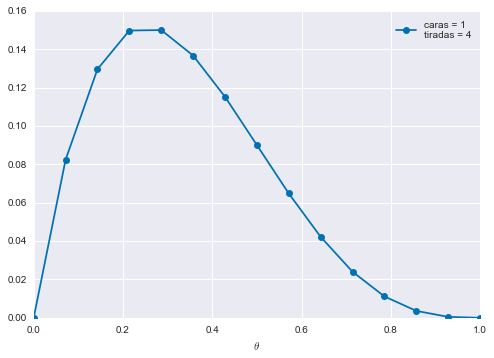

In [3]:
points = 15
h, n = 1, 4
grid, posterior = posterior_grid(points, h, n)
plt.plot(grid, posterior, 'o-', label='caras = {}\ntiradas = {}'.format(h, n))
plt.xlabel(r'$\theta$')
plt.legend(loc=0);

#### 1.2.2.2 Método cuadrático

Este método también se conoce como método de Laplace o aproximación normal y consiste en aproximar el _a posteriori_ usando una distribución Gaussiana. Esta aproximación funciona en general debido a que la región cercana a la moda del _a posteriori_ es aproximadamente Gaussiana (si no es exactamente Gaussiana!). Este método consiste en dos pasos

1. Encontrar la moda del _a posteriori_, por ejemplo usando un método de optimización, es decir un método que permite encontrar el mínimo/máximo de una función. Esta moda será la media de una Gaussiana.
2. Estimar la desviación estándard de la Gaussiana según la _curvatura local_ alrededor de la media.

Una vez que veamos como usar PyMC3 veremos un ejemplo de este método.

#### 1.2.2.3 Métodos variacionales

Gran parte de la estadística Bayesiana moderna hace uso de métodos MCMC, pero para algunos problemas estos métodos son demasiado lentos y no paralelizan necesariamente bien. La aproximación naive consistente en correr _n_ cadenas en paralelo y luego combinar los resultados, pero esta solución no siempre da buenos resultados. De hecho la búsqueda de formas efectivas de paralelizar métodos MCMC es una tema de investigación activo.

Los métodos variacionales suelen ser una buena opción para datasets grandes (grandes estilo big-data!) o para _likelihoods_ muy costosos de computar. Además estos métodos son útiles como aproximaciones rápidas al _posterior_ y como puntos de partida de métodos MCMC.

La idea general de los métodos variacionales es la de aproximar el _a posteriori_ con una distribucion más simple, como por ejemplo una Gaussiana. Esto suena similar al método cuadrático, pero las similitudes se desvanecen al entrar en los detalles del método. Tradicionalmente, uno de lo mayores inconvenientes de los métodos variacionales, es que eran modelo-específico. Por supuesto, mucha gente ha intentado encontrar métodos variacionales universales. Un método recientemente propuesto es [ADVI](http://arxiv.org/abs/1603.00788), por su nombre en ingles "Automatic Differentiation Variational Inference"


A nivel conceptual ADVI funciona de la siguiente forma:

1. Transformar los parámetros de forma tal que existan en los reales. 
Por ejemplo, Si un parámetro está restringido a los número positivos al tomar el logaritmo del mismo obtenemos que el parámetro ahora varía en el intervalo [\infty - \infty]

2. Aproximar la distribución del parámetro transformado usando una Gaussiana. 
Hay que notar que una Gaussiana en el espacio del parámetro transformado es no-Gaussiano en el espacio original. Esto es una clara diferencia con el método cuadrático.

3. Usar un método de optimización para ajustar la Gaussiana lo más posible al _a posteriori_. 
Esto se hace maximizando una cantidad conocida como Evidence Lower Bound (ELBO). Como se mide la similitud entre dos distribuciones y que es el ELBO exactamente, son detalles en este momento y no entraremos en ello.

## 1.3 El problema de la moneda revisitado, usando PyMC3 !

A continuación revisitaremos el problema de la moneda visto en el capítulo anterior, usando esta vez PyMC3 para definir nuestro modelo, hacer inferencia y analizar el _a posterori_! Luego veremos como resolver algunos otros problemas.

A continuación generaremos datos sintéticos, tal como hicimos antes.

In [4]:
np.random.seed(123)
n_experimentos = 4
theta_real = .35  # en una situación real este valor es desconocido
datos = stats.bernoulli.rvs(theta_real, size=n_experimentos)

In [5]:
datos

array([1, 0, 0, 0])

### 1.3.1 Creación del modelo

Ahora que tenemos nuestros datos es necesario especificar el modelo. Empezamos por el likelihood que viene dado por la distribución de bernoulli (cada uno de los elementos del array _datos_ es un experimento de Bernoulli), si en cambio tuviera el número total de "caras" obtenidas en varios experimentos de Bernoulli podríamos modelar el likelihood como una distribución Binomial, recordemos que la distribución Binomial es una generalización de la distribución de Bernoulli y corresponde con la distribución del número de _éxitos_ en una secuencia de $n$ experimentos si/no independientes entre si, donde cada uno de ellos da _éxito_ con probabilidad $\theta$.

Recordemos también que el _a priori_ lo habíamos definido como una distribución beta. En el siguiente ejemplo evaluaremos el caso en que los parámetros de esta distribución son $\alpha=\beta=1$, lo que equivale a una uniforme entre [0,1]. Dejamos como ejercicio el evaluar como cambian los resultados al cambiar estos parámetros y como los resultados se comparan con los obtenidos en el capítulo anterior.

Una forma resumida de expresar este modelo, usando notación habitualmente usada en estadística es la siguiente:

$$\theta \sim \operatorname{Beta}(\alpha=1, \beta=1)$$
$$y \sim \operatorname{Bin}(n=1, p=\theta)$$

Esta notación nos muestra de forma sintética que estamos modelando $\theta$ como si fuese una variable que proviene de una distribución Binomial con parámetros n=1 y p=p (o lo que es equivalente una distribución de Bernoulli). El valor de $p$ es desconocido, pero necesario para resolver el modelo y por ello lo hemos modelado como una distribución $\operatorname{Beta}(\alpha=1, \beta=1)$.

<img src="imagenes/modelo_2_moneda.png" width=100>

Esto modelo se traduce casi literalmente a PyMC3, veamos:

In [6]:
with pm.Model() as nuestro_primer_modelo:
    # a priori
    theta = pm.Beta('theta', alpha=1, beta=1)
    # likelihood
    y = pm.Bernoulli('y', p=theta, observed=datos)
    #y = pm.Binomial('theta',n=n_experimentos, p=theta, observed=sum(datos))

En la primer linea hemos creado un nuevo objeto llamado *nuestro_primer_modelo*. No es necesario saber los detalles de este objeto, basta con saber que es un contenedor para las variables aleatorias y todo lo relacionado con nuestro modelo. PyMC3 usa _with_ para indicar que todas las lineas que están dentro del bloque _with_ hacen referencia al mismo modelo (que en este caso se llama *nuestro_primer_modelo*). Esto se conoce como _syntactic sugar_ (azúcar sintáctico), es decir el uso de una sintaxis que tiene como único objetivo simplificar la forma de escribir o expresar algo.

La segunda linea de código, especifica el _a priori_, como pueden ver la sintaxis sigue de cerca a la notación matemática, la única diferencia es que el primer argumento es siempre una _cadena_ que especifica el nombre de la variable aleatoria (el nombre es usado internamente por Theano/PyMC3), este nombre siempre deberá coincidir con el nombre de la variable de Python a la que se le asigna. De no ser así el código correrá igual, pero puede conducir a errores y confusiones al analizar el modelo.

En este caso $\theta$ es una variables aleatorias estocásticas, es decir es una distribución de probabilidad determinada, en este caso, por las constantes $\alpha$ y $\beta$. Más adelante veremos que es posible además crear variables aleatorias deterministas, es decir variables cuyos valores están completamente determinados por los nodos parentales (aun cuando estos nodos sean estocásticos). Es importante recalcar que las variables de PyMC3 no son números si no distribuciones (o mejor dicho reglas para generar números a partir de distribuciones), con ellas es posible realizar muchas operaciones distintas, sumas, restas divisiones y multiplicaciones, como también operaciones  de algebra lineal como transposiciones, inversas y productos escalares.

En la tercer linea de código se especifica el _likelihood_, que como verán es similar a la linea anterior con la diferencia que hemos agregado un argumento llamado "observed" al cual le asignamos nuestros datos. Esta es la forma de indicarle a PyMC3 cuales son nuestros datos. Los datos pueden ser números, listas de Python, *arrays* de NumPy o *data_frames* de Pandas.

### 1.3.2 Inferencia

Nuestro modelo ya está completamente especificado, lo único que nos resta hacer es obtener el _a posteriori_. Una opción es hacerlo de forma analítica, pero como el título de este capitulo es _programación probabilística_ lo haremos con métodos numéricos. 

En PyMC3 la inferencia se realiza escribiendo las siguientes lineas:

In [7]:
with nuestro_primer_modelo:
    start = pm.find_MAP()
    step = pm.Metropolis(vars=[theta])
    trace = pm.sample(1000, step=step, start=start)

100%|██████████| 1000/1000 [00:00<00:00, 3228.85it/s]  | 1/1000 [00:00<02:26,  6.83it/s]

Optimization terminated successfully.
         Current function value: 3.819085
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6


Primero llamamos al objeto que definimos como nuestro modelo (*nuestro_primer_modelo*), indicando de esta forma que es sobre ese objeto que queremos realizar la inferencia. En la segunda linea se introduce el metodo *find_MAP*, MAP es _Máximo A Posteriori_ (por su sigla en inglés y castellano). El MAP es la moda del _a posteriori_ y puede ser encontrado usando métodos de optimización numérica. Si bien en algunos casos el MAP puede ser de utilidad en general no es lo que nos interesa, ya que el MAP puede tener algunos problemas: 

* Solo obtenemos una estimación puntual, no hay medida de la incerteza.
* La moda puede no ser representativa de la distribución
* La gran mayoría de los métodos para encontrar el MAP, solo encuentran máximos locales. Es decir no son útiles en distribuciones multimodales.

En este curso solo usaremos el MAP como punto _razonable_ desde donde iniciar el muestreo, en general el efecto es que la convergencia se logra antes. Esto es simplemente un _truco ad hoc_ y solo tiene que ver con el aspecto computacional del cálculo y no tiene nada que ver con la teoría Bayesiana en si misma.

En la tercer linea hemos definido que vamos a realizar el muestreo del _a posteriori_ usando Metropolis-Hastings (llamado simplemente Metropolis). Como veremos más adelante existen otros métodos de muestreo he incluso es posible combinar métodos de muestreo, asignado distintos métodos a distintas variables.

La última linea es la que ejecuta todo el código, el primer argumento es la cantidad de pasos y _step_ y _start_, son el método de muestreo y el punto desde donde iniciar el muestreo, respectivamente. _start_ es opcional.

### 1.3.3 Diagnóstico de los resultados

Una vez concluido el muestreo y antes de pasar a sacar conclusiones derivadas del _a posteriori_ deberemos evaluar si la cadena o _trace_ (es decir los valores obtenidos mediante el MCMC) es representativa del _a posteriori_. Si la cadena fuese infinita no habría ningún problema, ya que la teoria detrás de los MCMC garantizan resultados correctos. Como la cadena es finita debemos garantizar que sea lo suficientemente larga como para que las estimaciones sean precisas (segun nuestro requerimientos) y estables, es decir que en repetidas simulaciones obtengamos esencialmente el mismo resultado. A pesar de la importancia del problema y de las muchas propuestas que se han realizado, todavía no existen métodos automáticos que puedan ser aplicados a todos los problemas. Por lo tanto lo que se hace es realizar una serie de pruebas tanto vizuales como cuantitativas a fin de determinar si la cadena es representativa o no. En caso de que no lo sean existen esencialmente 4 soluciones, no mutuamente excluyentes para solucionar el problema:

1. Aumentar la cantidad de pasos del MCMC.
2. Eliminar los valores obtenidos en las primeras iteracciones. Esto se conoce como _burnin_. Los métodos MCMC suelen requerir de una cierta cantidad de iteraciones hasta que se logra converger a la distribución de equilibrio. Dado que solo nos son útiles las muestras provenientes de la distribucion de equilibrio, las primeras iteracciones suelen ser eliminadas. Algunos autores recomienda eliminar la primer mitad de la cadena generada (solo para estar seguros). En muchos problemas el número necesario suele ser menor, pero esto dependerá de la complejidad del modelo.
3. Hacer _thinning_ de la cadena. Esto es tomar una submuestra de la cadena a intervalos regulares, por ejemplo un valor de por medio, o cada 10 valores. En la práctica los métodos MCMC generan muestras que no son independientes entre si, tomar de a intervalos permite lograr muestras que se aproximen mejor al requerimiento de independencia.
4. Reparametrizar el modelo o cambiar el método de muestreo. Esto lo veremos recién en el capítulo sobre regresión lineal.

Veamos algunos de los métodos de diagnóstico

#### 1.3.3.1 Convergencia

Generalmente lo primero que uno quiere hacer es ver _que pinta_ tienen los resultados, para ello podemos usar la función de PyM3 _traceplot_. Traceplot nos muestra dos gráficos por cada parámetro que hayamos muestreado. A la izquierda se gráfica un KDE del _a posteriori_ para cada _variable aleatoria estocástica_ en el modelo (en este caso solo $\theta$). A la derecha se grafican los valores individuales de la cadena de Markov en forma secuencial, lo que se conoce como _trace_.

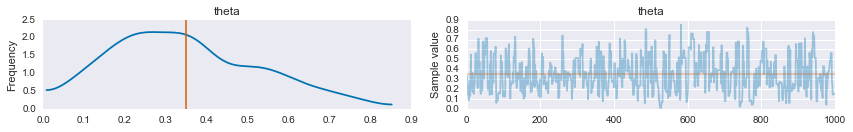

In [8]:
burnin = 0  # por ahora lo fijamos en 0, es decir nada de burnin
thin = 1  # por ahora lo fijamos en 1, es decir nada de thinning
pm.traceplot(trace[burnin::thin], varnames=['theta'], lines={'theta':theta_real});

Con el tiempo se logra ganar intuición sobre como deberían lucir estos gráficos cuando no hay problemas. En general, a medida que el número de datos aumenta se espera que las distribuciones marginales (es decir las distribuciones de cada parámetro por separado) se aproximen a Gaussianas (por la ley de los grande números), por supuesto esto no es siempre cierto. Pero en general uno espera al menos curvas relativamente suaves. En cuanto al *trace* uno espera que la curva _se mueva libremente_ subiendo y bajando por distintos valores sin quedarse estancada por mucho tiempo en un mismo valor o valores similares. Además, uno espera ver cierto grado de autosimilitud, es decir si la cadena realmente ha convergido, distintas porciones deberían lucir similares entre si. Si la primer parte es la que luce distinto al resto, tenemos indicios de la necesidad de _burnin_, si en cambio la falta de autosimilitud se observa en toda la cadena necesitamos más pasos o (si esto es muy costoso) necesitamos reparametrizar el modelo o cambiar el método de muestreo.

La función _summary_ provista por PyMC3 provee, en formato texto, de una serie de medidas estadísticas que se suelen usar para resumir el _a posteriori_alternativamente se puede usar la funcion *df_summary* que devuelve un _dataframe de Pandas_, en vez de texto plano. El _MC Error_ es una estimación del error introducido en el muestreo (y que tiene en cuenta que las muestras no son realmente independientes). Para calcularlo se divide a cadena en $n$ bloques y se calcula la media con los valores de cada bloque, a los valores así obtenidos ($X$) se les calcula el _error estándar de la media_.

$$MC_{error} = \frac{s(X)}{\sqrt{n}} $$

Este error deberá estar por debajo de la precisión que deseamos para nuestras estimaciones. Además, si el muestreo es realizado correctamente al repetir una simulación los valores de los parámetros estimados deberían mantenerse estables.

In [9]:
pm.df_summary(trace, varnames=['theta'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
theta,0.350253,0.178342,0.010699,0.063673,0.714188


Otra forma visual de diagnosticar el meustreo es observar las gráficas generadas por _traceplot_ pero para más de una simulació. PyMC permite correr varias simulaciones en simultaneo y analizarlas juntas en un mismo _trace plot_. Para ello la función _sample_ tiene el argumento _njobs_ el cual corresponde al número de simulaciones que queremos realizar. Si las curvas no se parecen entre si, puede ser que haga falta un mayor _burnin_ o un mayor número de muestras.

In [10]:
with nuestro_primer_modelo:
    step = pm.Metropolis()
    multi_trace = pm.sample(1000, step=step, njobs=4)

100%|██████████| 1000/1000 [00:00<00:00, 2192.72it/s]


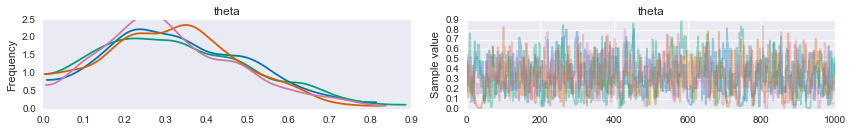

In [11]:
pm.traceplot(multi_trace[burnin::thin], varnames=['theta']);

Una forma cuantitativa de evaluar si hemos alcanzado la convergencia es mediante la prueba de Gelman-Rubin. Esta prueba se basa en comparar la varianza entre varias cadenas respecto de la varianza dentro de una misma cadena. Si se ha alcanzado la convergencia estas varianzas deberían ser iguales y deberíamos obtener un valor de $\hat R = 1$. Como regla empírica, se suele considerar que valores por encima de 1.1 podrían indicar la falta de convergencia.

In [12]:
pm.gelman_rubin(multi_trace)

{'theta': 1.001157123231516, 'theta_logodds_': 1.0007656645489353}

Otra forma de visualizar $\hat R$ es usando la función _forestplot_, que además muestra la media y los intervalos de credibilidad 95% y 50% para todas las variables del _a posteriori_.

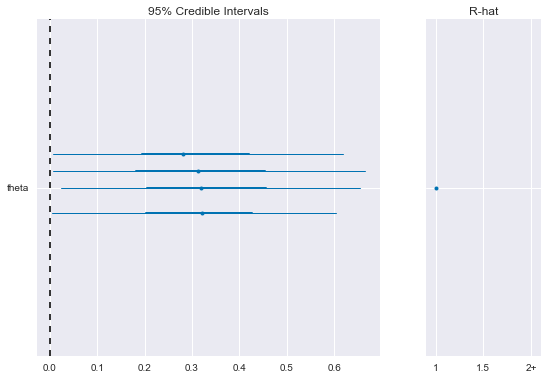

In [13]:
pm.forestplot(multi_trace, varnames=['theta']);

#### 1.3.3.2 Autocorrelación

Otra propiedad que es conveniente evaluar es la autocorrelación de la cadena, es decir la dependencia de un valor en la cadena respecto del anterior (o posterior). Las muestras generadas usando métodos MCMC, especialmente Metropolis-Hastings, pueden tener cierto grado de autocorrelación. Medir la autocorrelación suele ser util para dignosticar el correcto muestreo de nuestro modelo, por ello PyMC3 provee de la siguiente función.

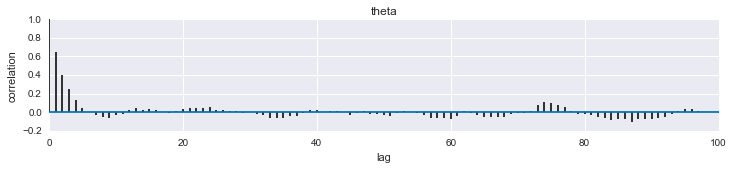

In [14]:
pm.autocorrplot(trace[burnin::thin], varnames=['theta']);

El gráfico muestra el grado de correlación observado para un punto en la cadena de Markov respecto de sucesivos puntos. Si, la autocorrelación es baja y solo se propaga para unos pocos puntos sucesivos (como en el anterior gráfico) entonces basta con hacer _thinning_ de la muestra, es decir tomar puntos de nuestra cadena cada una cierta cantidad de pasos. Si en cambio la correlación es grande y se propaga varias decenas de iteraciones, nos estará indicando que el método de muestreo tiene serios problemas para muestrear adecuadamente. Una solución es probar con otro método de muestreo. Si el problema persiste es probable que debamos introducir modificaciones en nuestro modelo (como veremos con los modelos de regresión lineal).

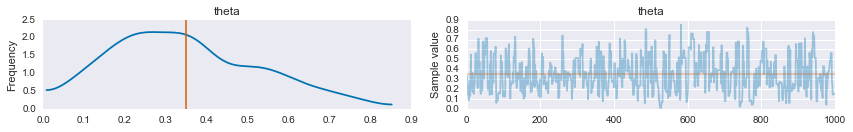

In [15]:
pm.traceplot(trace[burnin::thin], varnames=['theta'], lines={'theta':theta_real});

¿Cuán eficiente es el thinning?

La idea del _thinning_ es lograr aumentar la precision de las estimaciones obtenidas con el MCMC, mediante la reduccion de la autocorrelación. Sin embargo, varios autores([ref0](http://www.jstor.org/stable/2684714?seq=1#page_scan_tab_contents), [ref1](http://onlinelibrary.wiley.com/doi/10.1111/j.2041-210X.2011.00131.x/pdf)) han mostrado que realizar _thinning_, en general, no es más eficiente que simplemente aumentar la cantidad de pasos del MCMC. Intuitivamente la razón es la siguiente, al hacer _thinning_ logramos efectivamente eliminar la autocorrelación (lo que debería aumentar la precisión de la estimación) pero al mismo tiempo disminuimos la cantidad de puntos usados para aproximar la distribución lo que reduce la precisión! [Recientemente](http://arxiv.org/abs/1510.07727) se ha demostrado que el _thinning_ puede, en algunos casos, ser efectivo para aumentar la precisión. Segun este trabajo la cantidad de thinning necesaria debe ser estimada según el problema que tengamos y tiene relación con el costo computacional de evaluar cada paso del MCMC.

Otro uso común del _thinning_ se relaciona con disminuir el tamaño de la cadena a fin de facilitar su manipulación durante la fase de análisis del _a posteriori_.

#### 1.3.3.3 Tamaño efectivo de la muestra

Dado que las muestras obtenidas por MCMC poseen cierto grado de autocorrelación, una cadena de MCMC de longitud $n$ contiene menos información que una cadena de igual longitud pero de muestras realmente independientes. ¿Cuál sería el tamaño de nuestra muestra si fuera realmente independiente? La respuesta (estimada) a esa pregunta la ofrece el _tamaño efectivo de la muestra_ que se calcula teniendo en cuenta la autocorrelación. En el caso ideal ambas cantidades deberían ser iguales, en la práctica basta con que sean similares, mientras menor sea el tamaño efectivo respecto de las cantidad de muetras más ineficiente es nuestro muestreo (lo cual no necesariamente es un problema, si podemos afrontar el costo computacional).

Además, el tamaño efectivo de la muestra puede servirnos de guía para estimar cuan largas deben ser nuestras simulaciones según nuestro problema. Si nuestro interés esta centrado en calcular valores medios, entonces basta con un tamaño efectivo de aproximadamente 100, en cambio si nuestro interés está en estimar con precisión valores que dependen de la cola de las distribuciones como los límites de los intervalos de credibilidad entonces deberemos tener tamaños efectivos de al menos 10000. 

In [16]:
pm.effective_n(multi_trace[burnin::5])['theta'], len(multi_trace[burnin::5])*multi_trace.nchains

(564.0, 800)

Como puede verse todos las pruebas diagnósticas tienen una componente empírica y están relacionadas con aspectos computacionales y no directamente con la teoría Bayesiana/Probabilística.  En general ninguna de estas pruebas debe ser tomada como definitiva, si no como elementos de juicio que nos ayuden a tomar decisiones. Se recomienda el uso de una combinación de estas pruebas con un poco de juicio critico y escepticismo.

## 1.4 Para seguir leyendo

* Más sobre Teorema de Bayes y modelo binomial:
    * Capítulo 1 y 2 [Data Analysis: A Bayesian Tutorial](http://www.amazon.com/Data-Analysis-A-Bayesian-Tutorial/dp/0198568320) de Devinderjit Sivia & John Skilling
    * Capitulos 5 y 6 de Doing Bayesian Data Analysis de Kruschke (2 [edición](www.amazon.com/gp/product/0124058884))
    * Capitulo 1-4 de [Think Bayesian](http://greenteapress.com/thinkbayes/) de Allen B. Downey 
    * Capitulo 1 y 2 de [Bayesian Data Analysis](www.amazon.com/Bayesian-Analysis-Chapman-Statistical-Science/dp/1439840954) de Andrew Gelman

    
* Material online con tópicos Bayesianos:
    * [Publishable Stuff](http://sumsar.net/)
    * [Probably Overthinking It](http://allendowney.blogspot.com.ar/)
    * [Pythonic Perambulations](http://jakevdp.github.io./)
    * [While My MCMC Gently Samples](http://twiecki.github.io/)
    * [Count Bayesie](https://www.countbayesie.com/)
    * [Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/#contents)


* Las plantillas utilizadas para generar los diagramas de Kruschke, fueron creadas por [Rasmus Bååth's](http://sumsar.net/blog/2013/10/diy-kruschke-style-diagrams/)

In [17]:
import sys, IPython, scipy, matplotlib, platform
print("Esta notebook fue creada en una computadora %s corriendo %s y usando:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

Esta notebook fue creada en una computadora x86_64 corriendo debian stretch/sid y usando:
Python 3.5.2
IPython 5.1.0
PyMC3 3.0.rc4
NumPy 1.11.2
SciPy 0.18.1
Matplotlib 1.5.3
Seaborn 0.7.1

